# Crime Pattern in Los Angeles(2020-Present)

Yibin Hu

[Link to our GitHub webpage](https://yibhu.github.io/)

**Project Goals:**  
The primary goal of this project is to analyze and understand the crime patterns in Los Angeles by using two datasets, [Crime Data from 2020 to Present](https://catalog.data.gov/dataset/crime-data-from-2020-to-present) and [Median Income and AMI (census tract)](https://data.lacounty.gov/datasets/lacounty::median-income-and-ami-census-tract/about). This will not only provide insights into the nature of crimes but also help identify potential hotspots, temporal trends, and factors that might influence these crimes. The following are objectives:

1. **Temporal Analysis:**  
   - Identify trends in crime rates over time (e.g., monthly, annually).
   - Determine if certain times of the year or specific days are more prone to certain types of crimes.

2. **Geographical Analysis:**  
   - Identify high-crime areas or 'hotspots' within Los Angeles.
   - Analyze if certain types of crimes are more prevalent in specific regions.

3. **Predictive Analysis:**  
   - Build a classifer to predict the type of crime based on the features like time, location, and month of the year.
   

**The main intuition behind this model is that if there is a relation between crime and the states of the city (extracted and represented as features), and we know that the state of the city, then we may be able to extract information about the crime.**

This project aims to provide a overview of crime pattern in the city and build classifier that predict the crime type, which can aid law enforcement in better allocation of resources, policy-making, and public awareness initiatives.

In [1]:
!pip install geopandas
!pip install tqdm 

In [2]:
import requests
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import datetime as dt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
# map for crime codes and descent codes

crime_codes = {
    110: "Homicide",
    113: "Manslaughter",
    121: "Rape",
    122: "Attempted Rape",
    815: "Sexual Penetration w/ Foreign Object",
    820: "Oral Copulation",
    821: "Sodomy",
    210: "Robbery",
    220: "Robbery - attempted",
    230: "ADW (Assault with a Deadly Weapon)",
    231: "ADW against LAPD Police Officer",
    235: "Child beating",
    236: "Spousal beating",
    250: "Shots Fired",
    251: "Shots fired inhabited dwelling",
    761: "Brandishing",
    926: "Train Wrecking",
    435: "Lynching",
    436: "Lynching - attempted",
    437: "Resisting Arrest",
    622: "Battery on Firefighter",
    623: "Battery on Police Officer",
    624: "Battery - misdemeanor",
    625: "Spousal/Child Assault",
    626: "Other Misc. Assault - Simple Assault",
    627: "Child Abuse - Simple Assault",
    647: "Throwing substance at vehicle",
    653: "Stalking",
    928: "Threatening Phone Calls / Letters",
    930: "Criminal Threats",
    310: "Burglary",
    320: "Burglary - attempted",
    510: "Stolen Vehicle",
    520: "Stolen Vehicle - attempted",
    530: "DVWOC",
    331: "Burg from Vehicle",
    330: "Theft from vehicle - $950.01 & over",
    410: "Burg from Vehicle - attempted",
    420: "Theft from vehicle - $950 & under",
    421: "Theft from vehicle attempted",
    350: "Theft from person",
    351: "Purse snatch",
    352: "Pickpocket",
    353: "Drunk roll",
    450: "Theft from person - attempted",
    451: "Purse snatch - attempted",
    452: "Pickpocket - attempted",
    453: "Drunk roll - attempted",
    341: "Theft - $950.01 & over",
    343: "Shoplifting - $950.01 & over",
    345: "Dishonest employee - grand theft",
    440: "Theft - $950 & under",
    441: "Theft - attempted",
    442: "Shoplifting - $950 & under",
    443: "Shoplifting - attempted",
    444: "Dishonest employee - petty theft",
    445: "Dishonest Employee - attempted",
    470: "Till Tap - $950.01 & over",
    471: "Till Tap - $950 & under",
    472: "Till Tap - attempted",
    473: "Theft from coin m/c - $950.01 & over",
    474: "Theft from coin m/c - $950 & under",
    475: "Theft from coin m/c - attempted",
    480: "Bicycle - stolen",
    485: "Bicycle - attempted stolen",
    487: "Boat - stolen",
    491: "Boat - attempted stolen"
}

descent_code_dict = {
    'A': 'Other Asian',
    'B': 'Black',
    'C': 'Chinese',
    'D': 'Cambodian',
    'F': 'Filipino',
    'G': 'Guamanian',
    'H': 'Hispanic/Latin/Mexican',
    'I': 'American Indian/Alaskan Native',
    'J': 'Japanese',
    'K': 'Korean',
    'L': 'Laotian',
    'O': 'Other',
    'P': 'Pacific Islander',
    'S': 'Samoan',
    'U': 'Hawaiian',
    'V': 'Vietnamese',
    'W': 'White',
    'X': 'Unknown',
    'Z': 'Asian Indian'
}

# Extract and Load Data

Data Source: Crime Data from 2020 to Present from the City of Los Angeles

Data Collection: The data has been collected and published by the City of Los Angeles. It reflects incidents of crime in the City of Los Angeles dating back to 2020.


**Objectives:** loaded and explored the main dataset, Crime Data from 2020 to Present, and briefly discuss its content.

In [4]:
# the URL for the main dataset
url = 'https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD'

directory = 'datasets'
filename = 'Crime Data from 2020 to Present.csv'
path = os.path.join(directory, filename)

if not os.path.exists(directory):
    os.makedirs(directory)

if not os.path.exists(path):
    response = requests.get(url)
    with open(path, 'wb') as file:
        file.write(response.content)
    print(f"Downloaded the dataset to {path}")
else:
    print(f"The file {path} already exists.")

The file datasets\Crime Data from 2020 to Present.csv already exists.


**Table Info**

DR_NO: Records Number

Date Rptd: Date Reported 

AREA: Geographic Areas governed by 21 LAPD Police Stations are sequentially numbered from 1-21.

Rpt Dist No: A four-digit code that represents a sub-area within a Geographic Area.

Crm Cd Desc: Description of crime commited corresponding to Crm Cd, which is Crime code

Vict Age: Victim Age

Crm Cd: A case can have multiple Crime Code if multiple crimes are conducted


A more detailed column specification can be found in the [source website](https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8)

In [5]:
df = pd.read_csv('datasets/Crime Data from 2020 to Present.csv')

# Correct date types
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])

# Set 'LON' and 'LAT' to NaN where they are 0
df.loc[df['LON'] == 0, 'LON'] = np.nan
df.loc[df['LAT'] == 0, 'LAT'] = np.nan

display(df)  
display(df.dtypes)

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,2020-01-08,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,2020-01-02,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,2020-04-14,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
3,191501505,2020-01-01,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,2020-01-01,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847720,231606525,2023-03-22,03/22/2023 12:00:00 AM,1000,16,Foothill,1602,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,IC,Invest Cont,230.0,NaN,NaN,NaN,12800 FILMORE ST,NaN,34.2790,-118.4116
847721,231210064,2023-04-12,04/12/2023 12:00:00 AM,1630,12,77th Street,1239,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,IC,Invest Cont,230.0,NaN,NaN,NaN,6100 S VERMONT AV,NaN,33.9841,-118.2915
847722,230115220,2023-07-02,07/01/2023 12:00:00 AM,1,1,Central,154,1,352,PICKPOCKET,...,IC,Invest Cont,352.0,NaN,NaN,NaN,500 S MAIN ST,NaN,34.0467,-118.2485
847723,230906458,2023-03-05,03/05/2023 12:00:00 AM,900,9,Van Nuys,914,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,NaN,NaN,NaN,14500 HARTLAND ST,NaN,34.1951,-118.4487


DR_NO                      int64
Date Rptd         datetime64[ns]
DATE OCC                  object
TIME OCC                   int64
AREA                       int64
AREA NAME                 object
Rpt Dist No                int64
Part 1-2                   int64
Crm Cd                     int64
Crm Cd Desc               object
Mocodes                   object
Vict Age                   int64
Vict Sex                  object
Vict Descent              object
Premis Cd                float64
Premis Desc               object
Weapon Used Cd           float64
Weapon Desc               object
Status                    object
Status Desc               object
Crm Cd 1                 float64
Crm Cd 2                 float64
Crm Cd 3                 float64
Crm Cd 4                 float64
LOCATION                  object
Cross Street              object
LAT                      float64
LON                      float64
dtype: object

# Exploratory Data Analysis 

Plot the crimes over map, and from the geographical region where crimes happen, we can see there are region with high crime frequency. Although a hotspot is already seen in part of the city, a further investigation is required to study this phenomena to draw conclusion, since there are different types of crime with different serverity.

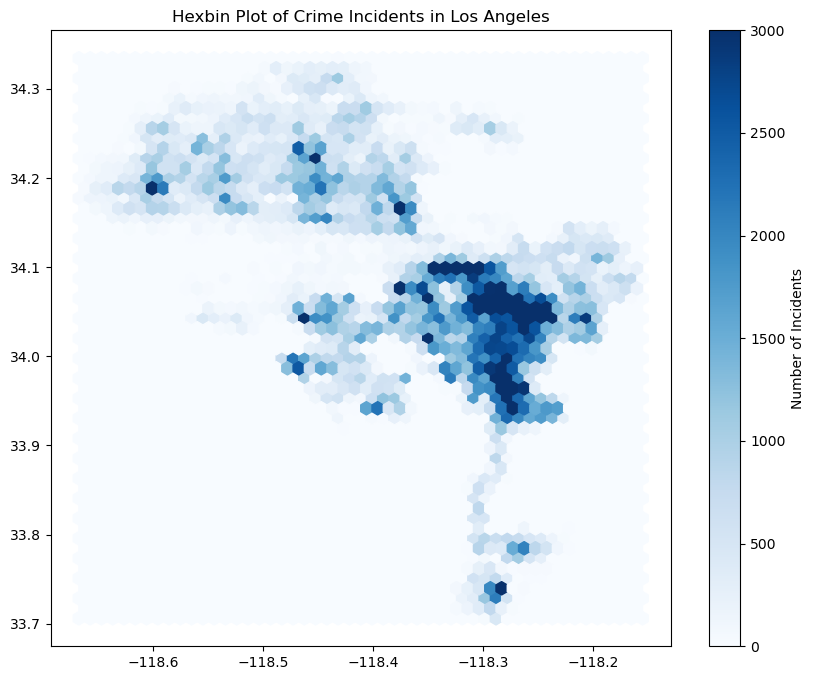

In [6]:
plt.figure(figsize=(10, 8))
hb = plt.hexbin(data=df, x="LON", y="LAT", gridsize=50, cmap="Blues", vmin=0, vmax=3000)
plt.colorbar(hb, label="Number of Incidents")
plt.title("Hexbin Plot of Crime Incidents in Los Angeles")
plt.show()

# New Dataset with Household Income Statistics

**Objectives:** Introduced new dataset, [Median Income and AMI (census tract)](https://data.lacounty.gov/datasets/lacounty::median-income-and-ami-census-tract/about), and did data cleaning and EDA oon the merged dataset.

In [7]:
import os
import requests
import zipfile

directory = 'datasets'  

# download the Median Income and AMI (census tract) dataset for Los Angeles
url = 'https://opendata.arcgis.com/api/v3/datasets/5455a5c504064c38b5ac9638d8580d92_0/downloads/data?format=csv&spatialRefId=4326&where=1%3D1'
filename = 'Median Income and AMI (census tract).csv'
path = os.path.join(directory, filename)

with open(path, "wb") as f:
    f.write(requests.get(url).content)

# download the shapefile which is used to convert longitude and latitude to census tract number
url = 'https://opendata.arcgis.com/api/v3/datasets/5455a5c504064c38b5ac9638d8580d92_0/downloads/data?format=shp&spatialRefId=4326&where=1%3D1'
filename = 'shapefile.zip'
path = os.path.join(directory, filename)

# download the shapefile zip file
response = requests.get(url)
if response.status_code == 200:
    with open(path, 'wb') as f:
        f.write(response.content)
    print(f"Shapefile zip downloaded to {directory}/{filename}")

    # Unzip the downloaded file
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(directory)
    print(f"Shapefile extracted to {directory}")
else:
    print(f"Failed to download the shapefile. Status code: {response.status_code}")


Shapefile zip downloaded to datasets/shapefile.zip
Shapefile extracted to datasets


In [8]:
import geopandas as gpd
from shapely.geometry import Point

df_hh = pd.read_csv('datasets/Median Income and AMI (census tract).csv') # load the household datasets

display(df_hh)

,tract,med_hh_income,med_hh_income_universe,ami_category,below_med_income,below_60pct_med_income,below_moderate_income,sup_dist,csa,spa,ESRI_OID,Shape__Area,Shape__Length
0,6037199700,38892.0,1204,Very Low Income,Yes,Yes,Yes,District 1,Los Angeles - Wholesale District,SPA 4 - Metro,2347,1.041050e+07,13808.463241
1,6037199801,41027.0,903,Very Low Income,Yes,Yes,Yes,District 1,Los Angeles - Lincoln Heights,SPA 4 - Metro,2348,3.724107e+06,9459.391827
2,6037199802,42500.0,612,Very Low Income,Yes,Yes,Yes,District 1,Los Angeles - Lincoln Heights,SPA 4 - Metro,2349,3.296129e+06,8868.744225
3,6037199900,37232.0,845,Very Low Income,Yes,Yes,Yes,District 1,Los Angeles - Lincoln Heights,SPA 4 - Metro,2350,4.782361e+06,10141.728022
4,6037201110,65000.0,782,Low Income,Yes,No,Yes,District 1,Los Angeles - El Sereno,SPA 4 - Metro,2351,1.099246e+07,15893.383636
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,6037554516,126450.0,1215,Above Moderate Income,No,No,No,District 4,City of Cerritos,SPA 7 - East,4837,1.555650e+07,21274.227408
2491,6037554517,107672.0,1352,Above Moderate Income,No,No,No,District 4,City of Cerritos,SPA 7 - East,4838,1.421767e+07,15905.089174
2492,6037554518,104439.0,1558,Above Moderate Income,No,No,No,District 4,City of Cerritos,SPA 7 - East,4839,1.938903e+07,21218.412991
2493,6037554519,131012.0,1216,Above Moderate Income,No,No,No,District 4,City of Cerritos,SPA 7 - East,4840,1.866694e+07,19500.866806


**Median Income and AMI (census tract).csv**

med_hh_income: median household income in this region

med_hh_income_universe: number of household in this region  

'06037231210'

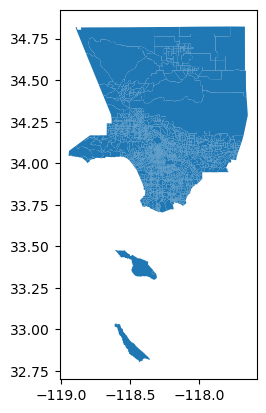

In [9]:
census_tracts_gdf = gpd.read_file('datasets/Median_Income_and_AMI_(census_tract).shp')

census_tracts_gdf.plot()

def get_census_tract(lat_lon, census_tracts_gdf):    
    lat, lon = lat_lon[0], lat_lon[1]
    
    # Create a GeoDataFrame with the given point
    point_gdf = gpd.GeoDataFrame([{'geometry': Point(lon, lat)}])
    
    # Ensure the GeoDataFrame uses the same CRS as the shapefile
    point_gdf.set_crs(census_tracts_gdf.crs, inplace=True)
    
    # Perform spatial join
    joined_gdf = gpd.sjoin(point_gdf, census_tracts_gdf, how="inner", predicate='intersects')
    
    # Extract the tract information
    if not joined_gdf.empty:
        return joined_gdf.iloc[0]['tract']
    else:
        return np.nan
    
# example use
get_census_tract((34.0141, -118.2978), census_tracts_gdf)

**process the main dataset (Crime Data from 2020 to Present)**

Columns to keep:
DATE OCC, TIME OCC, AREA, Crm Cd, Vict Age, Vict Sex, Vict Descent, LAT, LON
Crm Cd: Crime Code

In [10]:
import warnings
warnings.filterwarnings('ignore')

# process the main dataset (Crime Data from 2020 to Present)
columns_to_keep = ['DATE OCC', 'AREA', 'Crm Cd', 'Vict Age', 'Vict Sex', 'Vict Descent', 'LAT', 'LON']
df_crime = df[columns_to_keep]

df_crime['DATE OCC'] = df_crime['DATE OCC'].str.replace(' 12:00:00 AM', '')
df_crime['DATE OCC'] = pd.to_datetime(df_crime['DATE OCC'])

#display(df_crime)

**Merge the Crime Dataset with Household Income Dataset**

for each crime in crime dataset (df_crime), its latitude and longitude is fed into function get_census_tract that find the tract identifier that corresponds to a region in household income dataset (df_hh), and that region's household income and number of household is then added into the crime dataset to form a new dataset df_milestone2, which is used for analysis.


In [11]:
census_tracts_gdf.sindex

points_gdf = gpd.GeoDataFrame(df_crime, geometry=gpd.points_from_xy(df_crime.LON, df_crime.LAT))

# Perform the spatial join in one operation
joined_gdf = gpd.sjoin(points_gdf, census_tracts_gdf, how='left', predicate='intersects')

# Extract the tract information
df_crime['tract'] = joined_gdf['tract']
df_crime['tract'] = pd.to_numeric(df_crime['tract'])

#display(df_crime)

In [12]:
# Only to add household income and number of household 
df_household = df_hh[['tract', 'med_hh_income', 'med_hh_income_universe']]
df_household['tract'] = df_household['tract'].astype(np.float64)

display(df_household)

,tract,med_hh_income,med_hh_income_universe
0,6.037200e+09,38892.0,1204
1,6.037200e+09,41027.0,903
2,6.037200e+09,42500.0,612
3,6.037200e+09,37232.0,845
4,6.037201e+09,65000.0,782
...,...,...,...
2490,6.037555e+09,126450.0,1215
2491,6.037555e+09,107672.0,1352
2492,6.037555e+09,104439.0,1558
2493,6.037555e+09,131012.0,1216


**The dataframe after merging Crime data and Household Income data.**

In [13]:
df_milestone2 = pd.merge(df_crime, df_household, how='left', left_on='tract', right_on='tract')
df_milestone2.rename(columns={'med_hh_income': 'Median Household Income', 'med_hh_income_universe': 'Household'}, inplace=True)

display(df_milestone2)

,DATE OCC,AREA,Crm Cd,Vict Age,Vict Sex,Vict Descent,LAT,LON,tract,Median Household Income,Household
0,2020-01-08,3,624,36,F,B,34.0141,-118.2978,6.037231e+09,32454.0,1195.0
1,2020-01-01,1,624,25,M,H,34.0459,-118.2545,6.037208e+09,77213.0,2534.0
2,2020-02-13,1,845,0,X,X,34.0448,-118.2474,6.037206e+09,11153.0,1138.0
3,2020-01-01,15,745,76,F,W,34.1685,-118.4019,6.037125e+09,40668.0,1543.0
4,2020-01-01,19,740,31,X,X,34.2198,-118.4468,6.037120e+09,66806.0,1418.0
...,...,...,...,...,...,...,...,...,...,...,...
847720,2023-03-22,16,230,25,F,H,34.2790,-118.4116,6.037104e+09,45972.0,1155.0
847721,2023-04-12,12,230,29,M,B,33.9841,-118.2915,6.037237e+09,38750.0,992.0
847722,2023-07-01,1,352,24,F,H,34.0467,-118.2485,6.037207e+09,38305.0,1345.0
847723,2023-03-05,9,745,53,F,H,34.1951,-118.4487,6.037128e+09,45455.0,1504.0


**Data Cleaning**

In [14]:
# Checking for missing values in the df_milestone2
missing_values = df_milestone2.isnull().sum()

# Checking for duplicate rows in the df_milestone2
duplicate_rows = df_milestone2.duplicated().sum()

# Getting a general description of the df_milestone2 to understand the distributions
description = df_milestone2.describe(include='all')

# Display missing values and duplicate rows
print('duplicate_rows:', duplicate_rows, '\n', '--------------------------------------')
print('missing_values:', missing_values, '\n', '--------------------------------------')
print(f'Number of rows left is {df_milestone2.shape[0]}')

duplicate_rows: 9401 
 --------------------------------------
missing_values: DATE OCC                        0
AREA                            0
Crm Cd                          0
Vict Age                        0
Vict Sex                   111909
Vict Descent               111917
LAT                          2263
LON                          2263
tract                        2473
Median Household Income     18045
Household                    2473
dtype: int64 
 --------------------------------------
Number of rows left is 847725


In [15]:
# Fill missing numerical values with np.nan
numerical_columns = df_milestone2.select_dtypes(include=['float64', 'int64']).columns
df_milestone2[numerical_columns] = df_milestone2[numerical_columns].apply(lambda x: x.fillna(np.nan))

# Fill missing categorical values with 'X'
categorical_columns = df_milestone2.select_dtypes(include=['object']).columns
df_milestone2[categorical_columns] = df_milestone2[categorical_columns].apply(lambda x: x.fillna('X'))

# Standardize 'Vict Sex' values
df_milestone2['Vict Sex'] = df_milestone2['Vict Sex'].apply(lambda x: 'X' if x not in ['F', 'M'] else x)

# Standardize 'Vict Descent' values based on the provided description
valid_descent_codes = ['A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'O', 'P', 'S', 'U', 'V', 'W', 'Z']
df_milestone2['Vict Descent'] = df_milestone2['Vict Descent'].apply(lambda x: 'X' if x not in valid_descent_codes else x)

# drop all rows with missing numerical values and drop duplicates
df_milestone2_clean = df_milestone2.dropna(subset=['LAT', 'LON', 'Median Household Income', 'Household'])
df_milestone2_clean = df_milestone2_clean.drop_duplicates(keep='first')

print('duplicate_rows after clean:', df_milestone2_clean.duplicated().sum(), '\n', '--------------------------------------')
print('missing_values after clean:', df_milestone2_clean.isnull().sum(), '\n', '--------------------------------------')
print(f'Number of rows left is {df_milestone2_clean.shape[0]}')

duplicate_rows after clean: 0 
 --------------------------------------
missing_values after clean: DATE OCC                   0
AREA                       0
Crm Cd                     0
Vict Age                   0
Vict Sex                   0
Vict Descent               0
LAT                        0
LON                        0
tract                      0
Median Household Income    0
Household                  0
dtype: int64 
 --------------------------------------
Number of rows left is 820535


# EDA on the Merged Dataset

After merging crime dataset and household income dataset into one, a series of exploratory data analysis that tries to find interesting pattern and starts to think about model problem.

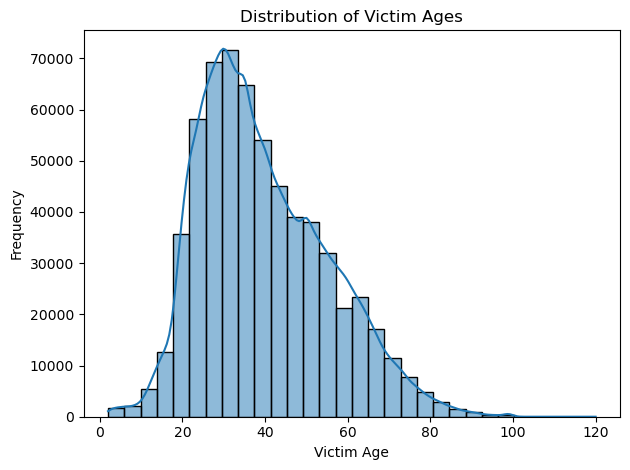

In [16]:
# distribution of victim agesplt.figure(figsize=(14, 7))
sns.histplot(data=df_milestone2_clean[df_milestone2_clean['Vict Age'] > 0], x='Vict Age', bins=30, kde=True)
plt.title('Distribution of Victim Ages')
plt.xlabel('Victim Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


**Distribution of Victim Ages**

This plot shows that the victims of crime in Los Angeles are mostly people of young to mid age.

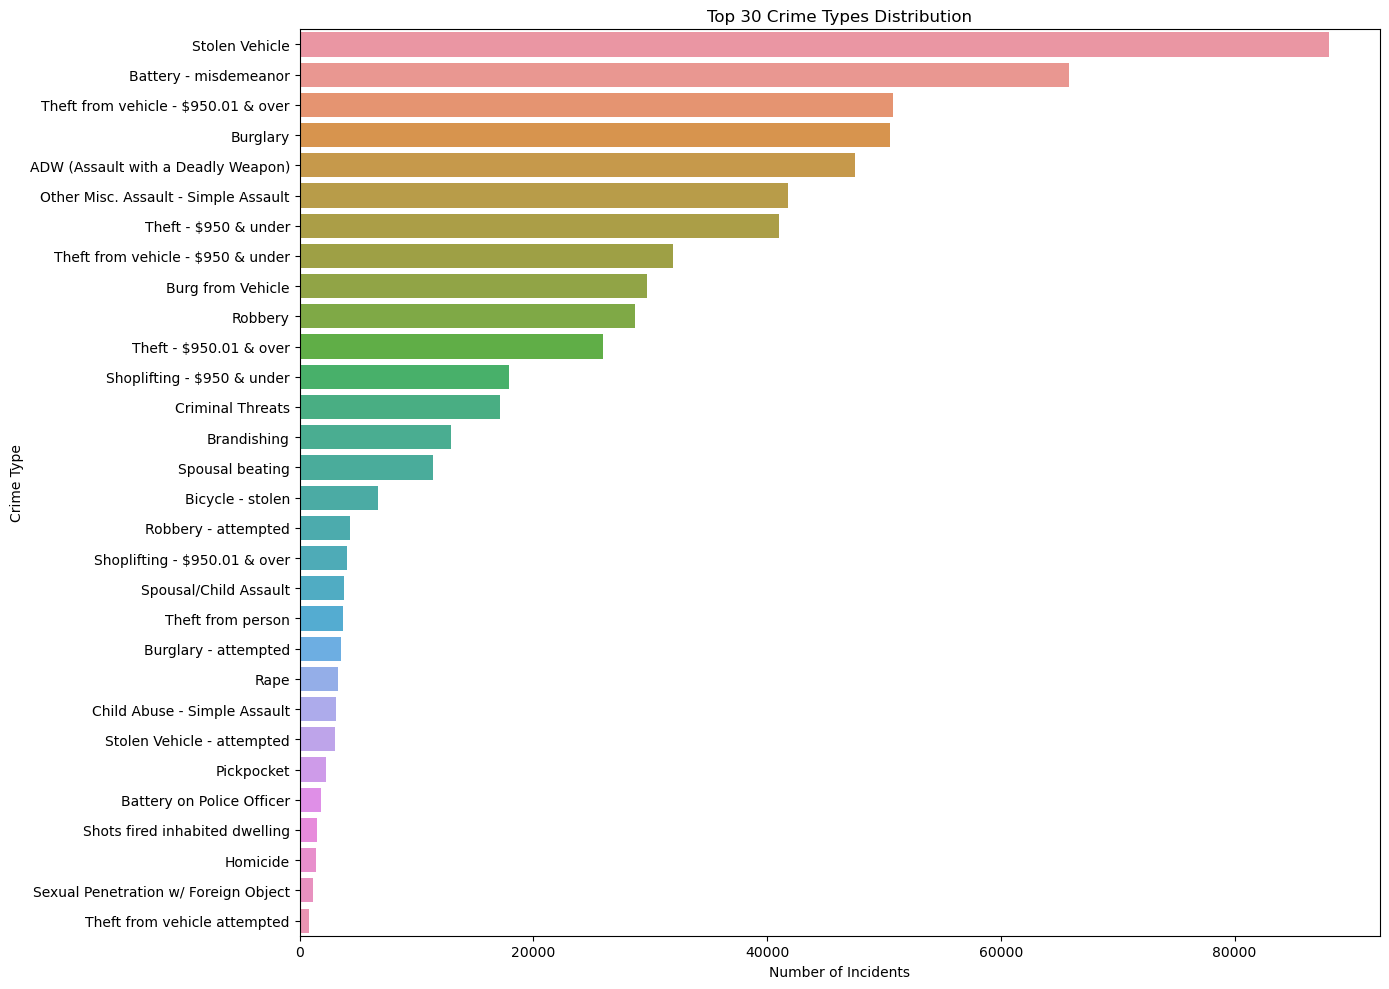

In [17]:
'''crime_codes is long and thus put in the end, run it first for this cell to work'''

df_milestone2_clean['Crm Cd Name'] = df_milestone2_clean['Crm Cd'].map(crime_codes)

# Create a count plot with crime names
plt.figure(figsize=(14, 10))
sns.countplot(
    data=df_milestone2_clean,
    y='Crm Cd Name',
    order=df_milestone2_clean['Crm Cd Name'].value_counts().iloc[:30].index
)

# Set the title and labels
plt.title('Top 30 Crime Types Distribution')
plt.xlabel('Number of Incidents')
plt.ylabel('Crime Type')  # Changed from 'Crime Code' to 'Crime Type'

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

**Top 30 Crime Types Distribution**

This plot shows the most frequent crimes, stolen vehicle is very prevalent in the city compared to other crimes.

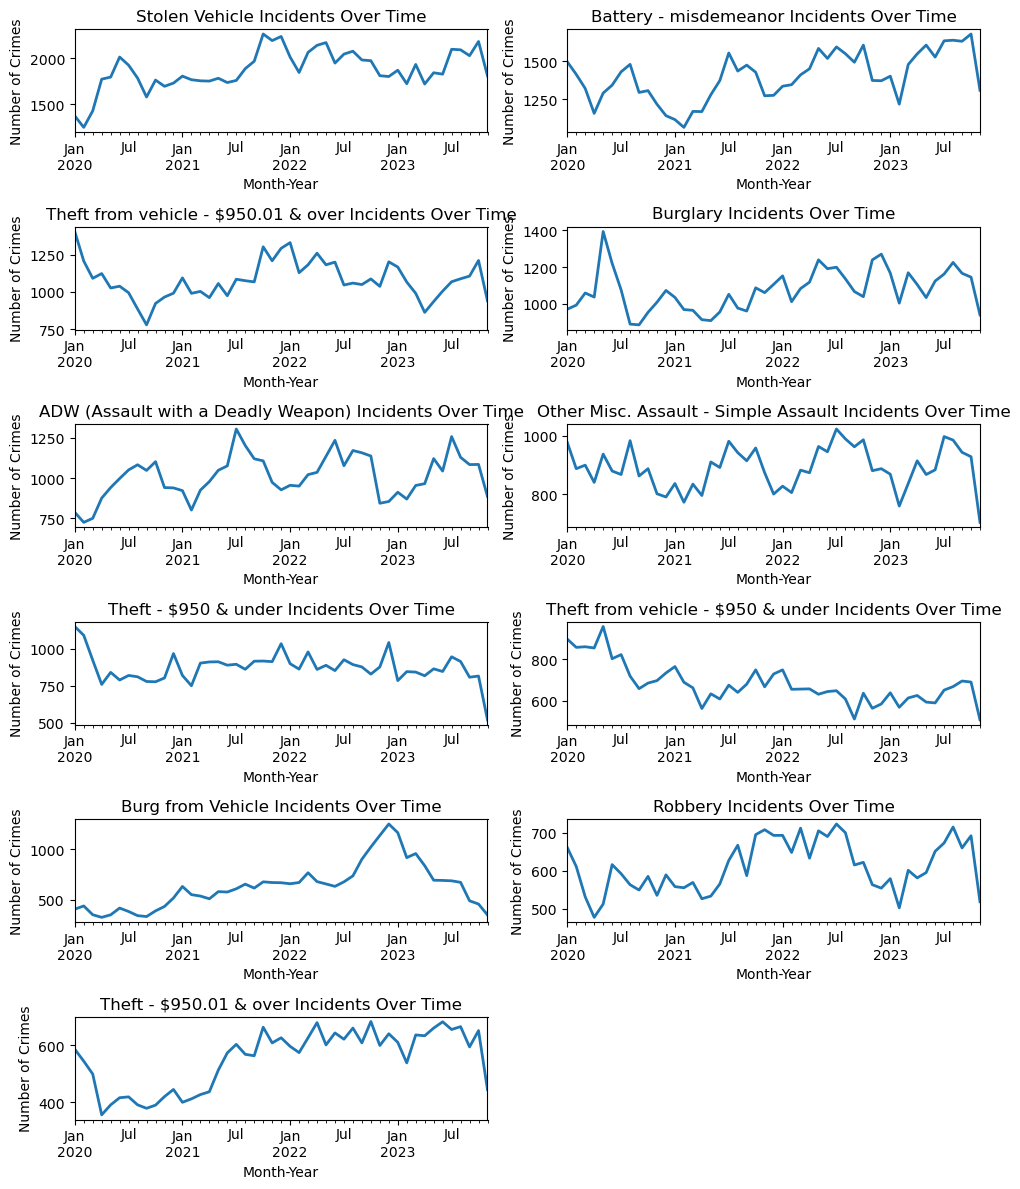

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get the names of the top 11 crimes
top_11_crimes = df_milestone2_clean['Crm Cd Name'].value_counts().head(11).index

plt.figure(figsize=(10, 12))

for i, crime in enumerate(top_11_crimes, 1):
    plt.subplot(6, 2, i)
    
    # Filter the DataFrame for each crime
    crime_data = df_milestone2_clean[df_milestone2_clean['Crm Cd Name'] == crime].copy()
    
    # Create a 'Month' column
    crime_data['Month'] = crime_data['DATE OCC'].dt.to_period('M')
    
    # Create a time series for the number of crimes per month
    crime_time_series = crime_data.groupby('Month').size().sort_index()
    
    # Plot the time series
    crime_time_series.plot(kind='line', linewidth=2)
    plt.title(f'{crime} Incidents Over Time')
    plt.xlabel('Month-Year')
    plt.ylabel('Number of Crimes')

plt.tight_layout()
plt.show()


**Incidents Over Time for Top 11 Crimes**

These plots show that different crime has diffent seasonal trend, and it is noted that trend of ADW seems to behave periodic behavior, and ADW crimes will experience a peak near July.

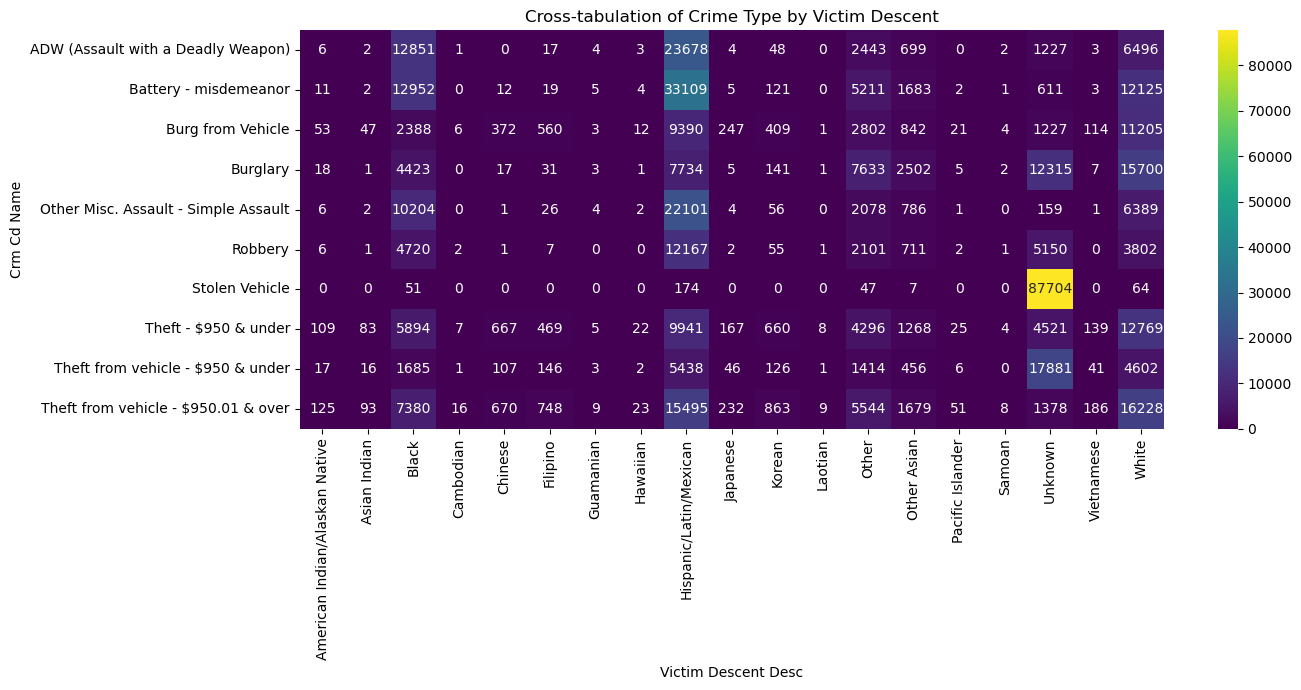

In [19]:
'''descent_code_dict is long and thus put in the end, run it first for this cell to work'''

df_milestone2_clean['Vict Descent Desc'] = df_milestone2_clean['Vict Descent'].map(descent_code_dict)

# Heatmap of crime type by victim descent for the top 10 most common crime types for visibility
top_crime_types = df_milestone2_clean['Crm Cd Name'].value_counts().head(10).index
cross_tab_crime_descent = pd.crosstab(df_milestone2_clean[df_milestone2_clean['Crm Cd Name'].isin(top_crime_types)]['Crm Cd Name'], df_milestone2_clean['Vict Descent Desc'])
plt.figure(figsize=(14, 7))
sns.heatmap(cross_tab_crime_descent, annot=True, fmt='d', cmap='viridis')
plt.title('Cross-tabulation of Crime Type by Victim Descent')
plt.xlabel('Victim Descent Desc')
plt.ylabel('Crm Cd Name')
plt.tight_layout()
plt.show()

**Cross-tabulation of Crime Type by Victim Descent**

This plot shows the contingency between Crime and Victim Descent. It is found that some races seems to be more susceptible to crime, which should be confirmed in next plot.

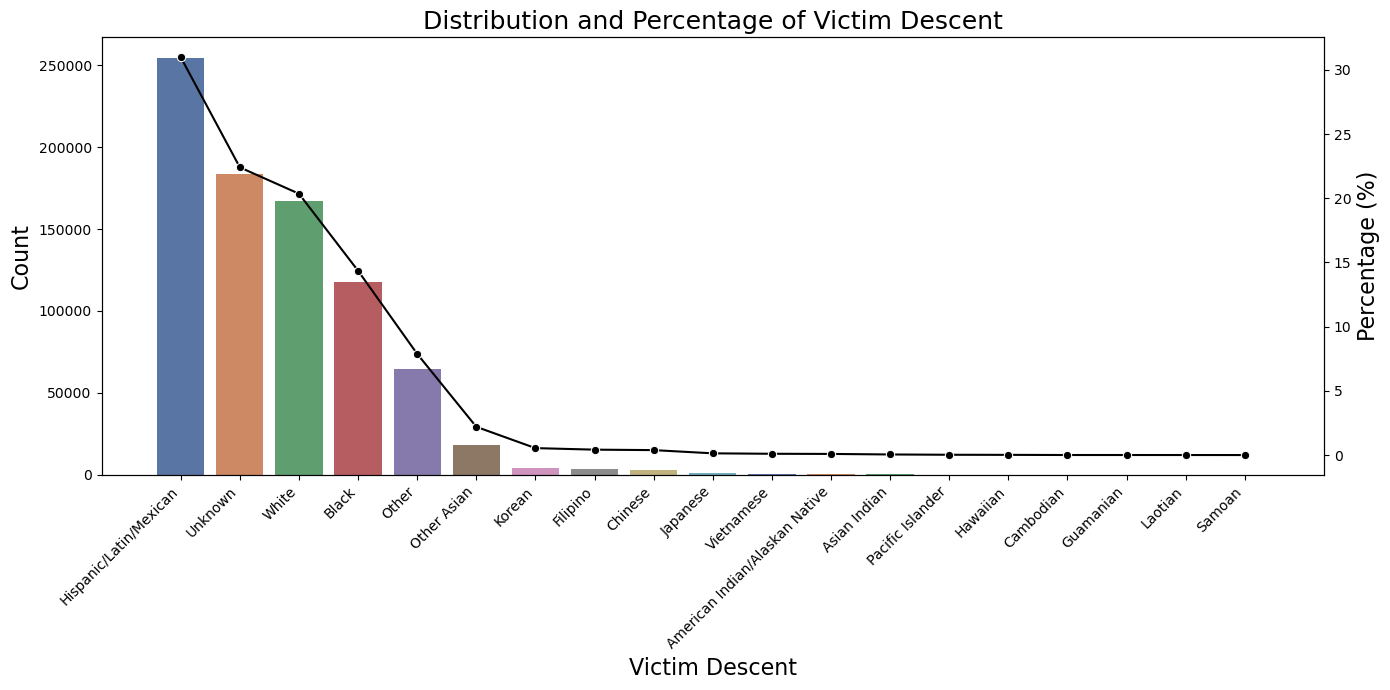

In [20]:
# For this plot, we need to calculate the count and percentage of each victim descent

descent_counts = df_milestone2_clean['Vict Descent Desc'].value_counts()

total_samples = len(df_milestone2_clean)
descent_percentage = (descent_counts / total_samples) * 100

fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plot for counts
sns.barplot(x=descent_counts.index, y=descent_counts.values, ax=ax1, palette="deep")
ax1.set_ylabel('Count', fontsize=16)
ax1.set_xlabel('Victim Descent', fontsize=16)
ax1.set_title('Distribution and Percentage of Victim Descent', fontsize=18)

# Rotate x-axis labels to prevent overlap
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')

# Create another axis for the percentages
ax2 = ax1.twinx()

# Line plot for percentages
sns.lineplot(x=descent_counts.index, y=descent_percentage.values, ax=ax2, sort=False, color='black', marker="o")
ax2.set_ylabel('Percentage (%)', fontsize=16)

plt.tight_layout()
plt.show()


**Distribution and Percentage of Victim Descent**

This plot shows that the number of crimes happens to a race is proportional to the pertenage of the race, which means that race is the most dominant factor affecting crime.

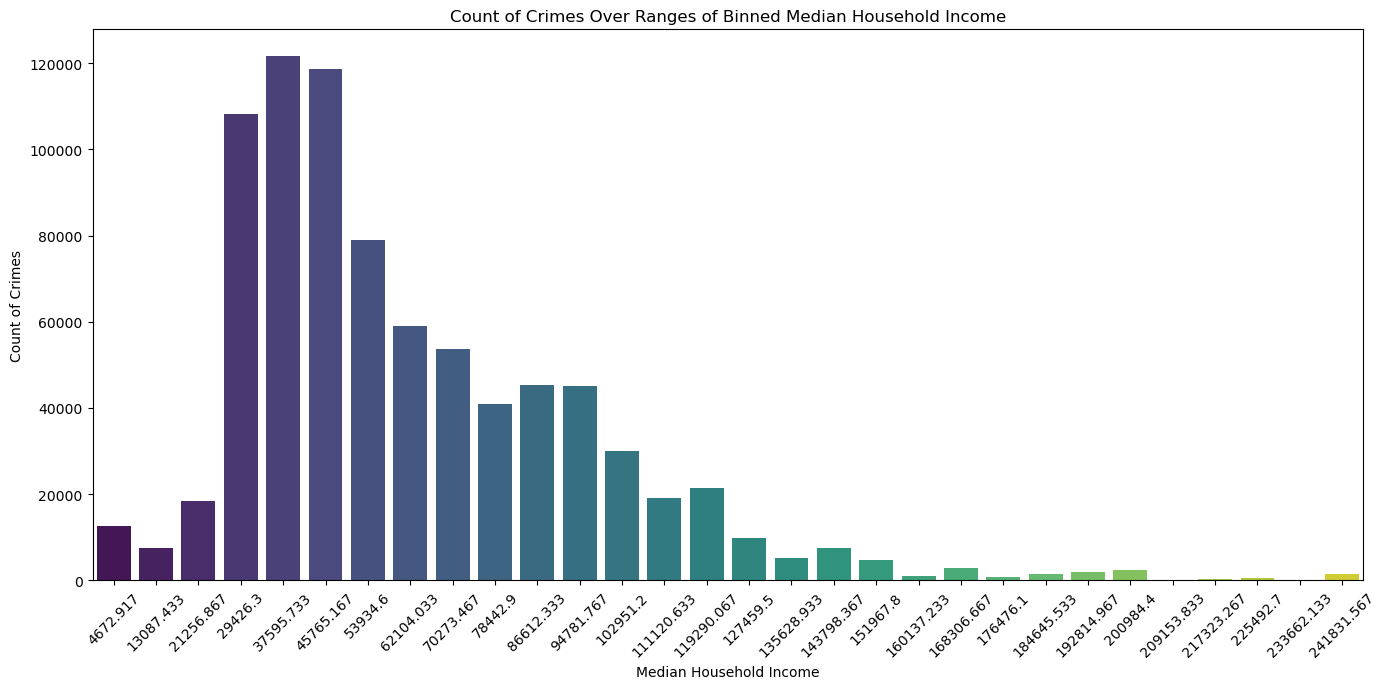

In [21]:
# histogram of count of crimes over the range of binned median household income

# Define the number of bins for the histogram
bins = pd.cut(df_milestone2_clean['Median Household Income'], bins=30)

# Group by the income bins and count the number of crimes in each bin
income_crime_count = df_milestone2_clean.groupby(bins)['Crm Cd'].agg('count').reset_index(name='Count')

# Extract the lower bound of each bin interval for the x-axis
income_crime_count['Income Range Start'] = income_crime_count['Median Household Income'].apply(lambda x: x.left)

# Plot the histogram
plt.figure(figsize=(14, 7))
sns.barplot(x=income_crime_count['Income Range Start'].astype(str), y=income_crime_count['Count'], palette="viridis")

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45)

plt.title('Count of Crimes Over Ranges of Binned Median Household Income')
plt.xlabel('Median Household Income')
plt.ylabel('Count of Crimes')

plt.tight_layout()
plt.show()


**Count of Crimes Over Ranges of Binned Median Household Income**

This plot shows that region with medium income has most of the crimes, since rich region tend to have better security while poorer region don't have good target.

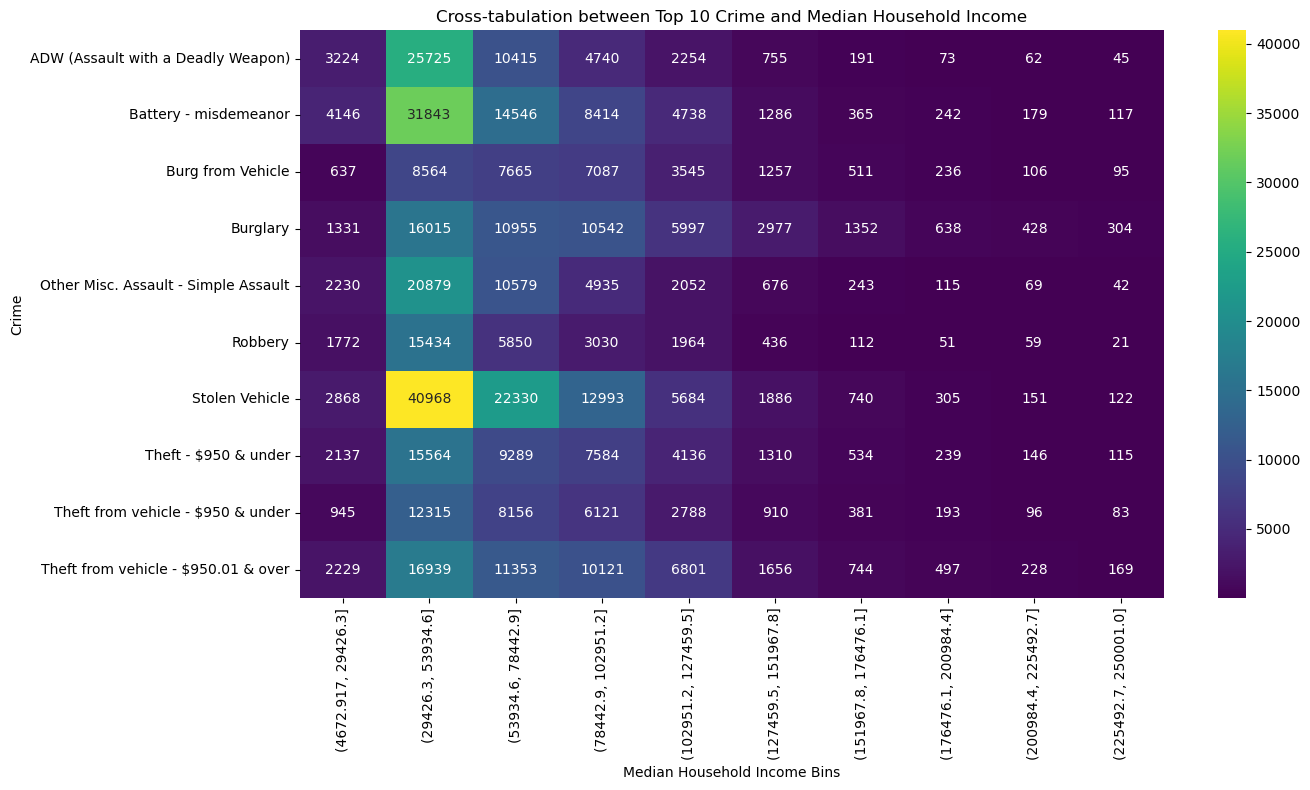

In [22]:
# The cross-tabulation between crime code and median household income for top 10 crime

# Create income bins
df_milestone2_clean['Income Bin'] = pd.cut(df_milestone2_clean['Median Household Income'], bins=10)

# Identify the top 10 crimes
top_10_crimes = df_milestone2_clean['Crm Cd Name'].value_counts().head(10).index

# Create a cross-tabulation of the top 10 crime codes and income bins
cross_tab_crime_income = pd.crosstab(df_milestone2_clean[df_milestone2_clean['Crm Cd Name'].isin(top_10_crimes)]['Crm Cd Name'], df_milestone2_clean['Income Bin'])

plt.figure(figsize=(14, 8))
sns.heatmap(cross_tab_crime_income, annot=True, fmt='d', cmap='viridis')
plt.title('Cross-tabulation between Top 10 Crime and Median Household Income')
plt.xlabel('Median Household Income Bins')
plt.ylabel('Crime')
plt.tight_layout()
plt.show()

**Cross-tabulation between Top 10 Crime and Median Household Income**

This plot shows additional information that the income has different impact on crime rate for different crimes.

In [23]:
data = df_milestone2_clean
#data.to_csv('data.csv', index=False)

display(data)

,DATE OCC,AREA,Crm Cd,Vict Age,Vict Sex,Vict Descent,LAT,LON,tract,Median Household Income,Household,Crm Cd Name,Vict Descent Desc,Income Bin
0,2020-01-08,3,624,36,F,B,34.0141,-118.2978,6.037231e+09,32454.0,1195.0,Battery - misdemeanor,Black,"(29426.3, 53934.6]"
1,2020-01-01,1,624,25,M,H,34.0459,-118.2545,6.037208e+09,77213.0,2534.0,Battery - misdemeanor,Hispanic/Latin/Mexican,"(53934.6, 78442.9]"
2,2020-02-13,1,845,0,X,X,34.0448,-118.2474,6.037206e+09,11153.0,1138.0,NaN,Unknown,"(4672.917, 29426.3]"
3,2020-01-01,15,745,76,F,W,34.1685,-118.4019,6.037125e+09,40668.0,1543.0,NaN,White,"(29426.3, 53934.6]"
4,2020-01-01,19,740,31,X,X,34.2198,-118.4468,6.037120e+09,66806.0,1418.0,NaN,Unknown,"(53934.6, 78442.9]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847720,2023-03-22,16,230,25,F,H,34.2790,-118.4116,6.037104e+09,45972.0,1155.0,ADW (Assault with a Deadly Weapon),Hispanic/Latin/Mexican,"(29426.3, 53934.6]"
847721,2023-04-12,12,230,29,M,B,33.9841,-118.2915,6.037237e+09,38750.0,992.0,ADW (Assault with a Deadly Weapon),Black,"(29426.3, 53934.6]"
847722,2023-07-01,1,352,24,F,H,34.0467,-118.2485,6.037207e+09,38305.0,1345.0,Pickpocket,Hispanic/Latin/Mexican,"(29426.3, 53934.6]"
847723,2023-03-05,9,745,53,F,H,34.1951,-118.4487,6.037128e+09,45455.0,1504.0,NaN,Hispanic/Latin/Mexican,"(29426.3, 53934.6]"


In [24]:
# identify the top 11 most frequent crime types.

crime_counts = data['Crm Cd Name'].value_counts().head(11)
top_crimes = crime_counts.index.tolist()

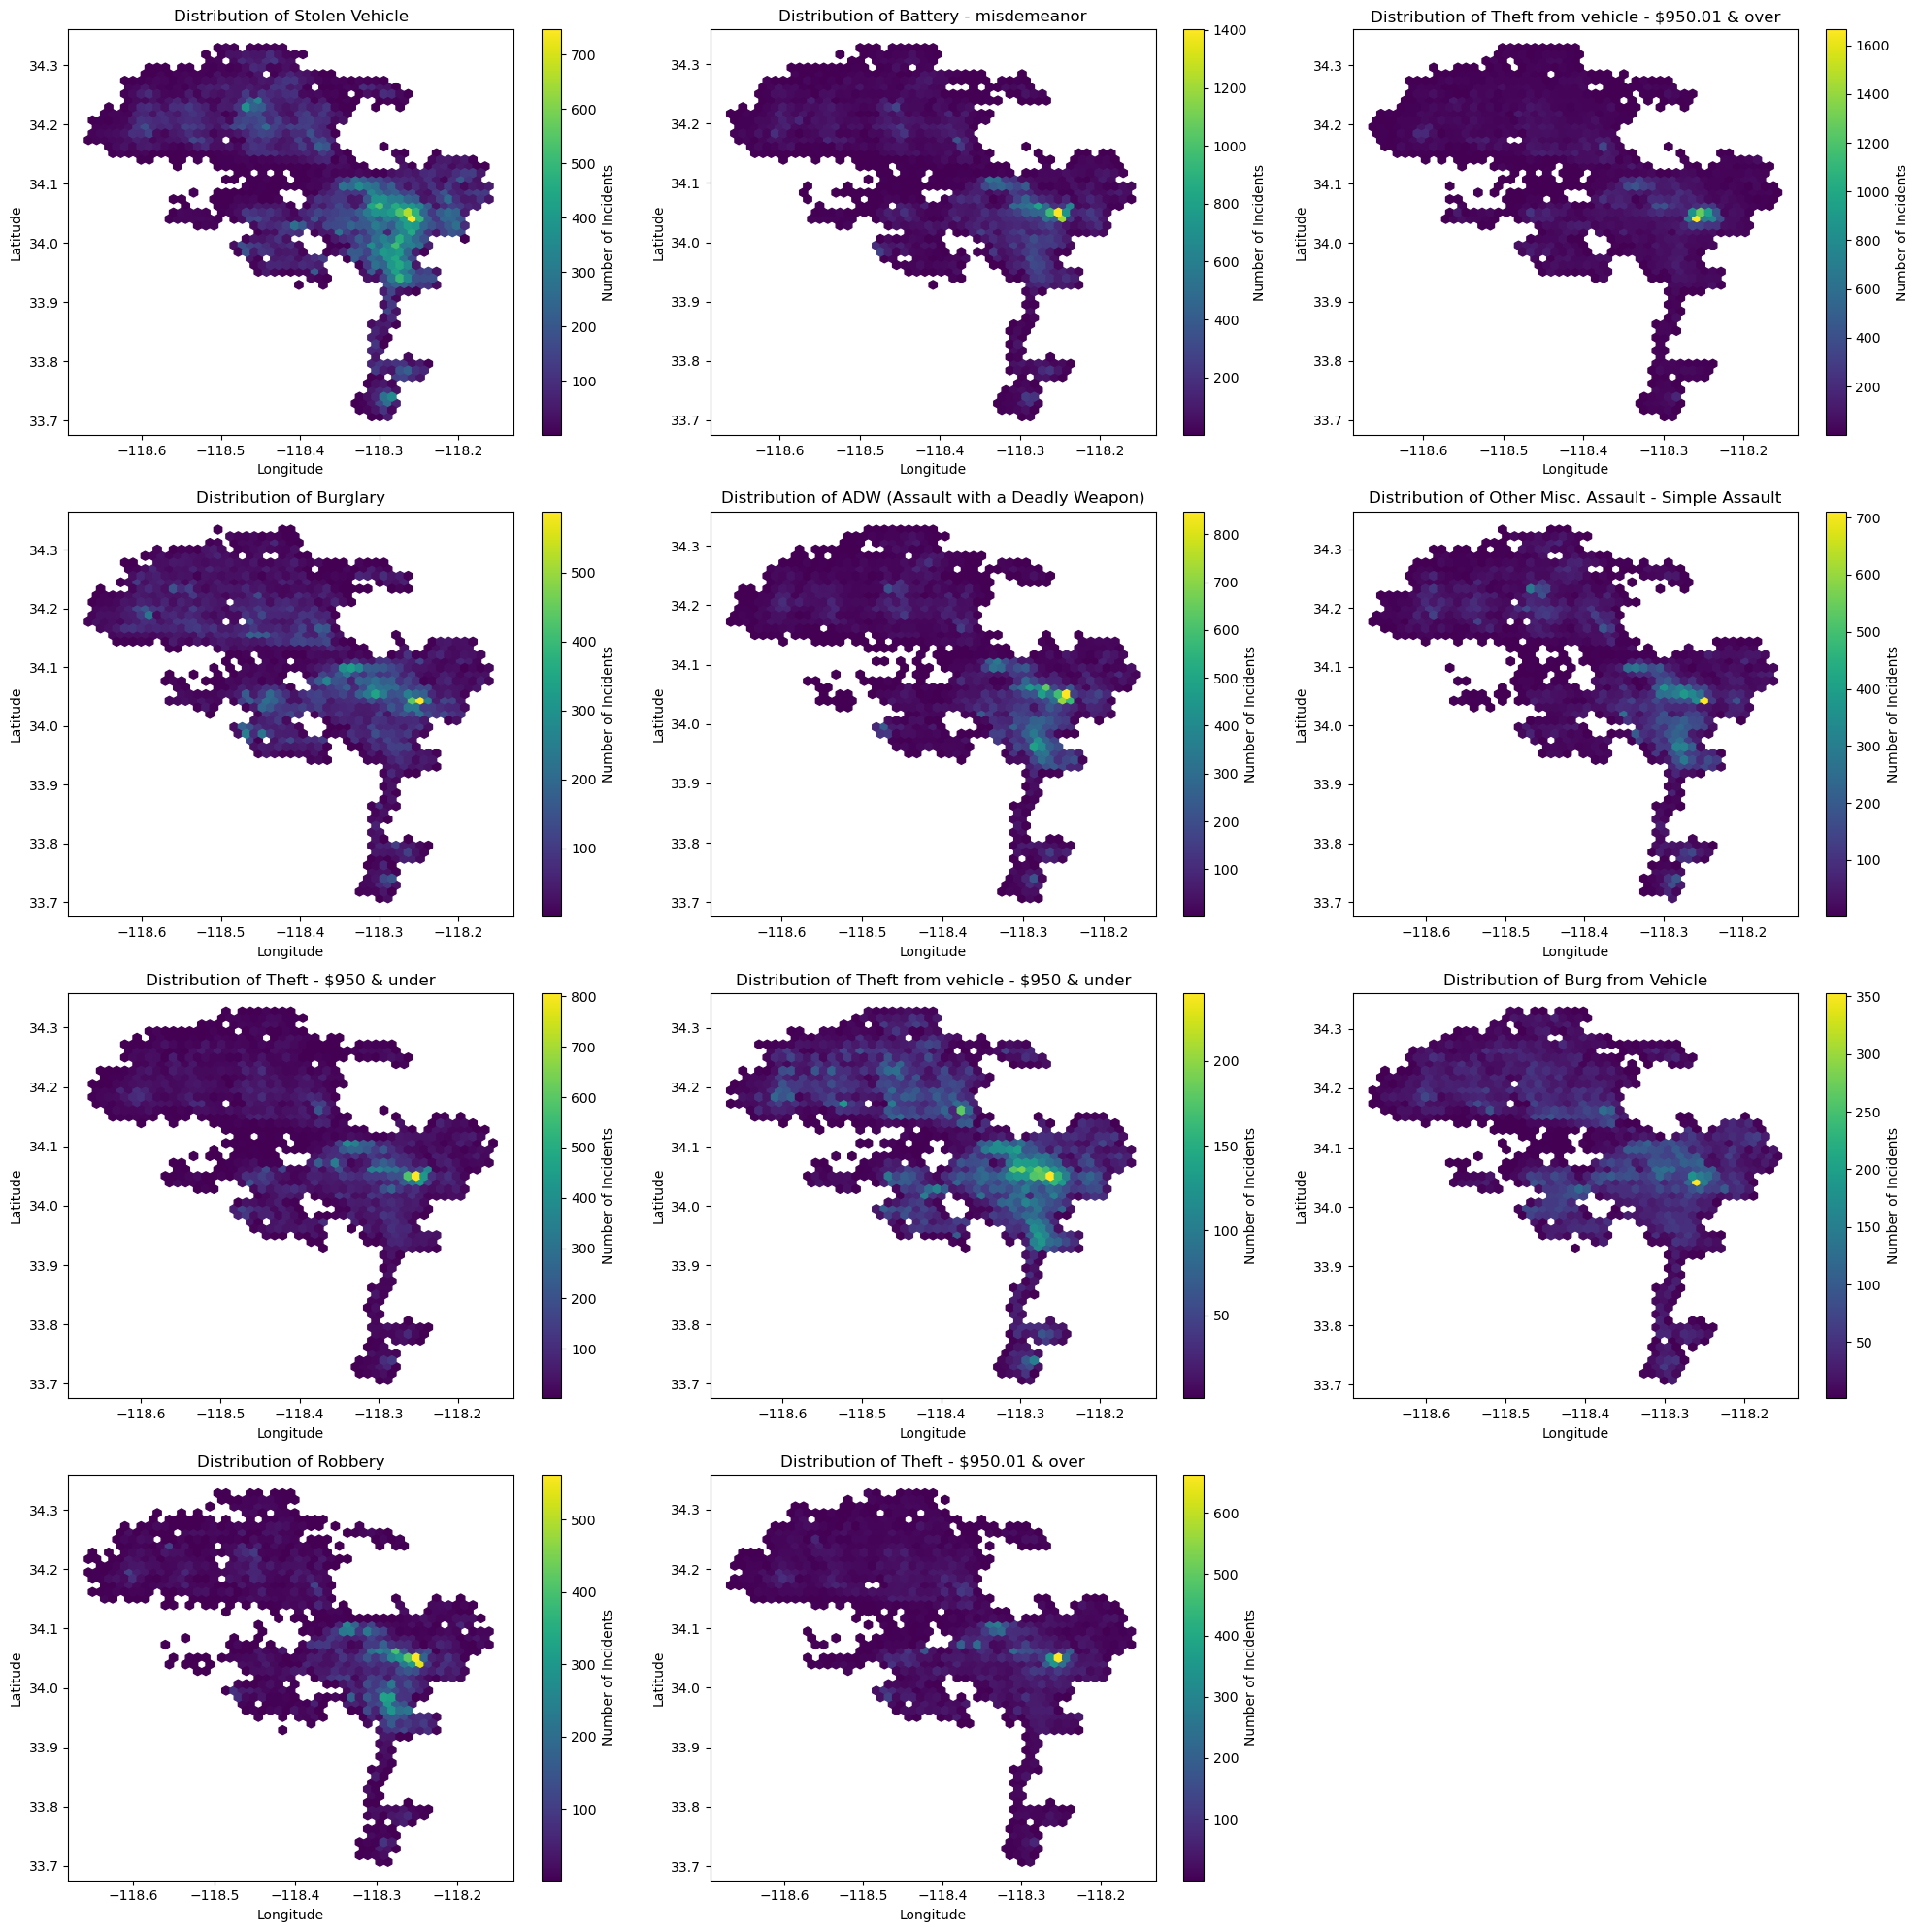

In [25]:
top_crimes_data = data[data['Crm Cd Name'].isin(top_crimes)]

num_rows = 4
num_cols = 3

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 20))
axes = axes.flatten()

for i, crime in enumerate(top_crimes):
    if i >= len(top_crimes):
        break  
    
    crime_data = top_crimes_data[top_crimes_data['Crm Cd Name'] == crime]
    
    hb = axes[i].hexbin(x=crime_data['LON'], y=crime_data['LAT'], gridsize=50, cmap='viridis', mincnt=1)
    
    axes[i].set_title(f'Distribution of {crime}')
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')
    
    plt.colorbar(hb, ax=axes[i], label="Number of Incidents")

for j in range(len(top_crimes), num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.show()


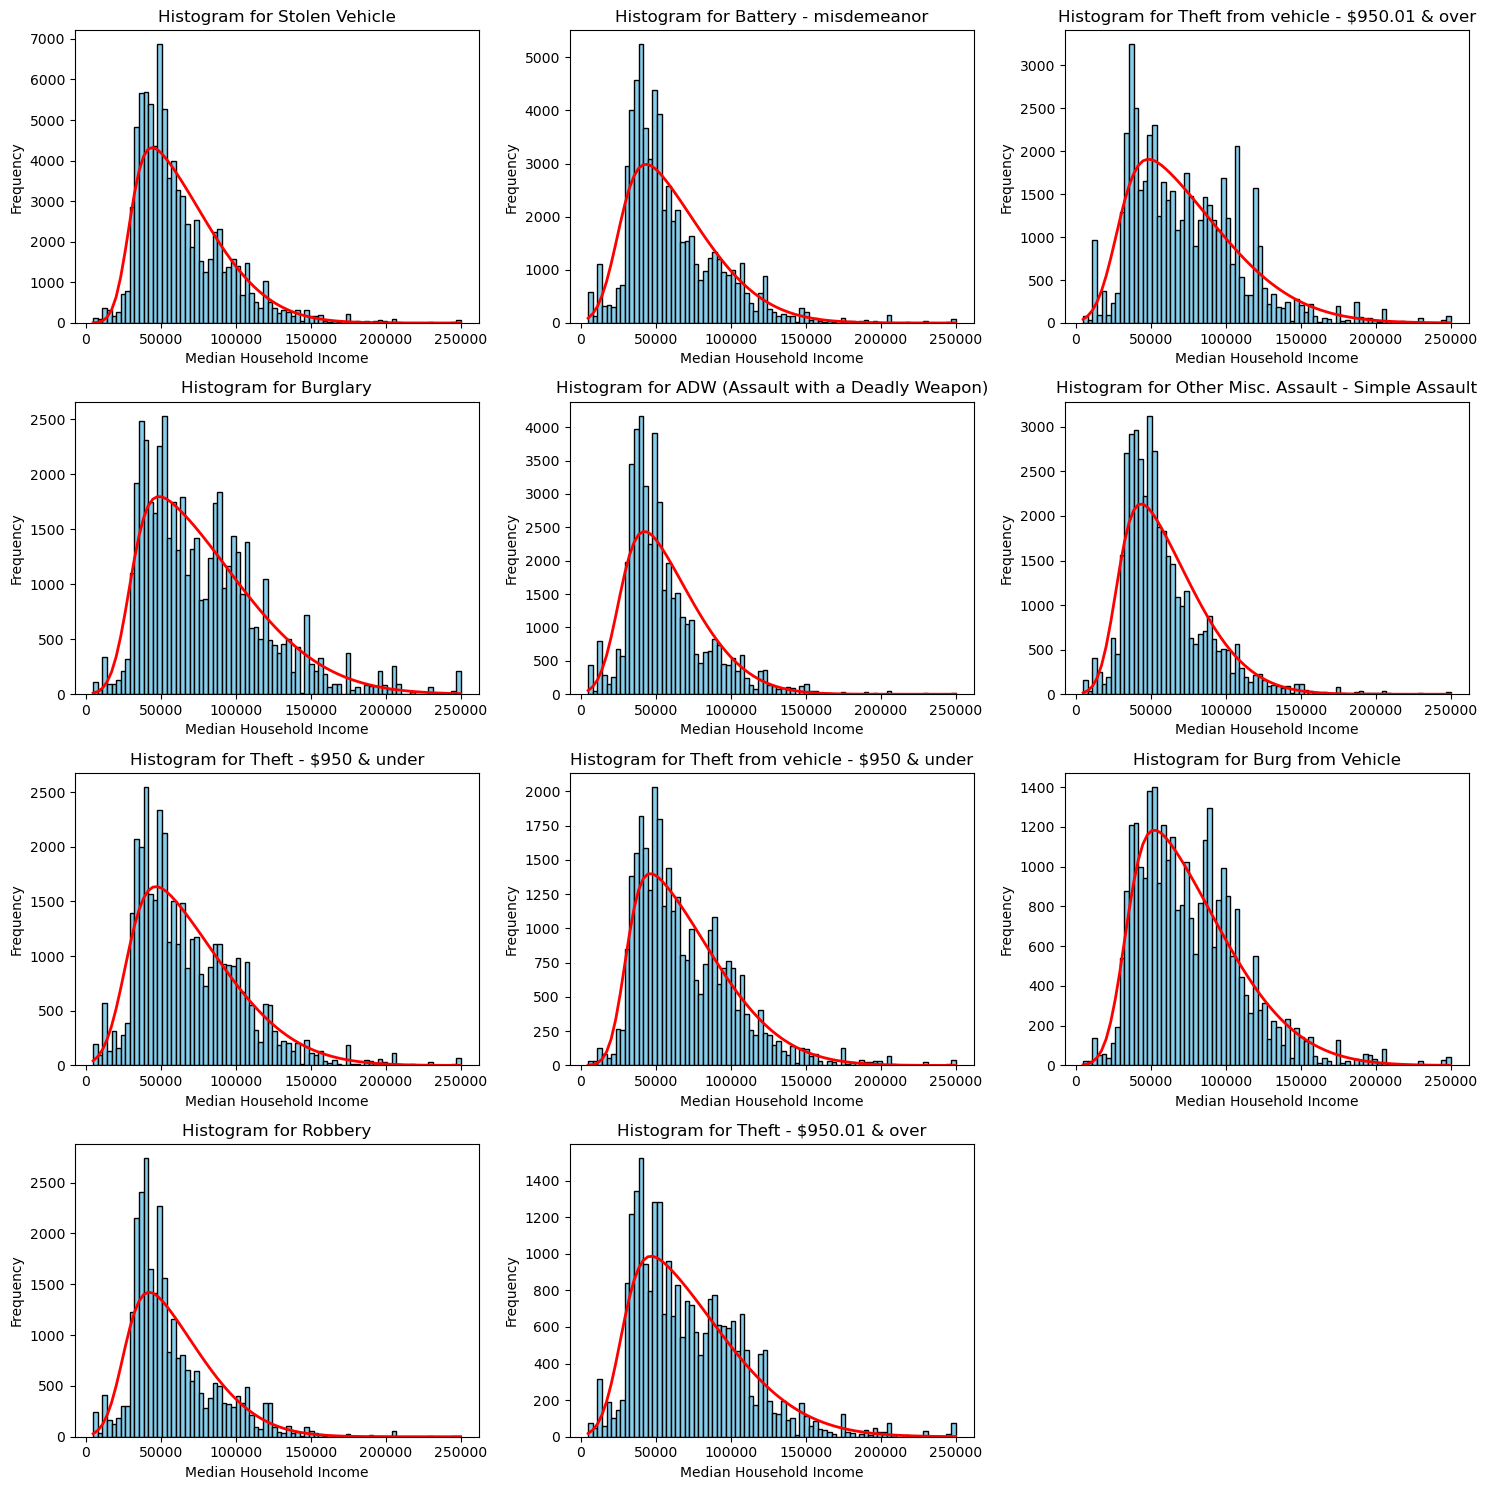

In [26]:
from scipy.stats import skewnorm

num_rows = 4
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = axes.flatten()

for i, crime in enumerate(top_crimes):
    crime_specific_data = top_crimes_data[top_crimes_data['Crm Cd Name'] == crime]

    counts, bins, _ = axes[i].hist(crime_specific_data['Median Household Income'], bins=80, color='skyblue', edgecolor='black')
    
    params = skewnorm.fit(crime_specific_data['Median Household Income'])
    
    pdf = skewnorm.pdf(bins, *params)
    
    axes[i].plot(bins, pdf * sum(counts) * (bins[1] - bins[0]), 'r-', lw=2)
    
    axes[i].set_title(f'Histogram for {crime}')
    axes[i].set_xlabel('Median Household Income')
    axes[i].set_ylabel('Frequency')

for j in range(len(top_crimes), num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [27]:
data_sample = top_crimes_data.iloc[:len(data) // 10]
display(data_sample)

,DATE OCC,AREA,Crm Cd,Vict Age,Vict Sex,Vict Descent,LAT,LON,tract,Median Household Income,Household,Crm Cd Name,Vict Descent Desc,Income Bin
0,2020-01-08,3,624,36,F,B,34.0141,-118.2978,6.037231e+09,32454.0,1195.0,Battery - misdemeanor,Black,"(29426.3, 53934.6]"
1,2020-01-01,1,624,25,M,H,34.0459,-118.2545,6.037208e+09,77213.0,2534.0,Battery - misdemeanor,Hispanic/Latin/Mexican,"(53934.6, 78442.9]"
8,2020-01-04,1,341,23,M,B,34.0677,-118.2398,6.037198e+09,52250.0,2141.0,Theft - $950.01 & over,Black,"(29426.3, 53934.6]"
9,2020-05-26,17,341,0,X,X,34.2864,-118.5021,6.037107e+09,112273.0,1144.0,Theft - $950.01 & over,Unknown,"(102951.2, 127459.5]"
10,2020-01-04,1,330,29,M,A,34.0359,-118.2648,6.037224e+09,36604.0,1558.0,Theft from vehicle - $950.01 & over,Other Asian,"(29426.3, 53934.6]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135589,2020-06-24,14,330,33,M,W,33.9598,-118.3962,6.037276e+09,140446.0,2657.0,Theft from vehicle - $950.01 & over,White,"(127459.5, 151967.8]"
135591,2020-11-01,15,440,0,M,O,34.1478,-118.4071,6.037144e+09,119816.0,2373.0,Theft - $950 & under,Other,"(102951.2, 127459.5]"
135594,2020-02-10,18,510,0,X,X,33.9529,-118.2651,6.037240e+09,50521.0,1248.0,Stolen Vehicle,Unknown,"(29426.3, 53934.6]"
135596,2020-01-25,12,330,29,M,H,33.9511,-118.3079,6.037238e+09,65313.0,2408.0,Theft from vehicle - $950.01 & over,Hispanic/Latin/Mexican,"(53934.6, 78442.9]"


# Random Forest Calssifer 


From above data exploration, it is seen there is a relation between crime and feature like household income and location, this motivates to build up a classifier that predict the type of crime happening at the state given the state of the city. A state refers to a list of features like area, latitude, longitude,  household income, and engineered features.

**Performance of Random Predictor**

In [28]:
import random

data_sample = top_crimes_data.iloc[:len(data) // 10]
crime_counts = data_sample['Crm Cd Name'].value_counts()
print(crime_counts)

# Total number of crimes
total_crimes = sum(crime_counts.values)

# Calculate the probability distribution of the crimes
probabilities = {crime: count / total_crimes for crime, count in crime_counts.items()}

# Generate actual labels (assuming each crime occurs as many times as its count)
actual_labels = []
for crime, count in crime_counts.items():
    actual_labels.extend([crime] * count)

# Generate random predictions based on the probability distribution
random_predictions = np.random.choice(list(probabilities.keys()), size=total_crimes, p=list(probabilities.values()))

# Calculate the accuracy of the random predictor
accuracy = accuracy_score(actual_labels, random_predictions)
print("Accuracy of the random predictor: {:.3f}".format(accuracy))


Stolen Vehicle                          12576
Battery - misdemeanor                   11220
Theft from vehicle - $950.01 & over      8825
Burglary                                 8708
Theft - $950 & under                     7393
ADW (Assault with a Deadly Weapon)       7263
Other Misc. Assault - Simple Assault     6969
Theft from vehicle - $950 & under        6205
Burg from Vehicle                        4685
Robbery                                  4514
Theft - $950.01 & over                   3695
Name: Crm Cd Name, dtype: int64
Accuracy of the random predictor: 0.101


The sampled dataset is not extremely unbanlanced, and we see that random predictor only achieves 10% accuracy.

**Performance of Random Forest with Feature Engineering**

Below are some feature engineering that could be considered.

1. **Temporal Feature Engineering:**
   - Seasons: Convert the 'month' feature into a 'season' feature (Spring, Summer, Fall, Winter).
   - Weekend/Weekday: Create a binary feature indicating whether the crime occurred on a weekend or a weekday.
   - Time Since Last Crime: For each location, calculate the time elapsed since the last recorded crime.

2. **Spatial Feature Engineering:**
   - Population Density: If data is available, calculate the population density of the area where the crime occurred.

3. **Crime History Features:**
   - Recent Crime Count: Number of crimes in the area in the last week/month.
   - Crime Type Frequency: Frequency of each type of crime in the area over a certain period.
   
4. **Interaction Features:**
   - Time-Area Interaction: Interactions between time (like part of the day) and area or location clusters.
   - Income-Time Interaction: Interactions between income features and time-related features (e.g., higher-income crimes on weekends).

**(New data is required for following features)**

**Temporal Feature Engineering:**
   - Public Holidays: Include a feature indicating whether the crime occurred on a public holiday.

**Spatial Feature Engineering:**
   - Proximity Features: Distance to nearest key locations such as police stations, bars, schools, or parks.

**Environmental Features:**
   - Weather Conditions: Temperature, precipitation, etc., at the time of the crime.

**Demographic Features:**
   - Age Distribution: Distribution of age groups in the area.
   - Ethnic Composition: Diversity index or major ethnic groups’ proportions.



In [29]:
# only 1/10 of total data is used due to the long time needed to train
data_engineered = top_crimes_data.iloc[:len(top_crimes_data) // 10].copy(deep=True)

def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    
data_engineered['DATE OCC'] = pd.to_datetime(data_engineered['DATE OCC'])
data_engineered['day_of_week'] = data_engineered['DATE OCC'].dt.dayofweek
data_engineered['month'] = data_engineered['DATE OCC'].dt.month
data_engineered['hour'] = data_engineered['DATE OCC'].dt.hour
data_engineered['part_of_day'] = pd.cut(data_engineered['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
data_engineered['season'] = data_engineered['month'].apply(month_to_season)
data_engineered['is_weekend'] = data_engineered['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

print(len(data_engineered))
display(data_engineered)
data_engineered.to_csv('data_engineered.csv', index=False)

50190


,DATE OCC,AREA,Crm Cd,Vict Age,Vict Sex,Vict Descent,LAT,LON,tract,Median Household Income,Household,Crm Cd Name,Vict Descent Desc,Income Bin,day_of_week,month,hour,part_of_day,season,is_weekend
0,2020-01-08,3,624,36,F,B,34.0141,-118.2978,6.037231e+09,32454.0,1195.0,Battery - misdemeanor,Black,"(29426.3, 53934.6]",2,1,0,Night,Winter,0
1,2020-01-01,1,624,25,M,H,34.0459,-118.2545,6.037208e+09,77213.0,2534.0,Battery - misdemeanor,Hispanic/Latin/Mexican,"(53934.6, 78442.9]",2,1,0,Night,Winter,0
8,2020-01-04,1,341,23,M,B,34.0677,-118.2398,6.037198e+09,52250.0,2141.0,Theft - $950.01 & over,Black,"(29426.3, 53934.6]",5,1,0,Night,Winter,1
9,2020-05-26,17,341,0,X,X,34.2864,-118.5021,6.037107e+09,112273.0,1144.0,Theft - $950.01 & over,Unknown,"(102951.2, 127459.5]",1,5,0,Night,Spring,0
10,2020-01-04,1,330,29,M,A,34.0359,-118.2648,6.037224e+09,36604.0,1558.0,Theft from vehicle - $950.01 & over,Other Asian,"(29426.3, 53934.6]",5,1,0,Night,Winter,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81875,2020-09-22,6,510,0,X,X,34.0958,-118.3180,6.037191e+09,50417.0,1573.0,Stolen Vehicle,Unknown,"(29426.3, 53934.6]",1,9,0,Night,Fall,0
81877,2020-06-17,11,510,0,X,X,34.0888,-118.2212,6.037185e+09,67076.0,907.0,Stolen Vehicle,Unknown,"(53934.6, 78442.9]",2,6,0,Night,Summer,0
81878,2020-06-18,11,330,46,M,B,34.0786,-118.2615,6.037196e+09,53145.0,1264.0,Theft from vehicle - $950.01 & over,Black,"(29426.3, 53934.6]",3,6,0,Night,Summer,0
81883,2020-11-07,6,210,23,M,B,34.1016,-118.3387,6.037190e+09,40723.0,2286.0,Robbery,Black,"(29426.3, 53934.6]",5,11,0,Night,Fall,1


In [30]:
print(top_crimes_data.dtypes)

DATE OCC                   datetime64[ns]
AREA                                int64
Crm Cd                              int64
Vict Age                            int64
Vict Sex                           object
Vict Descent                       object
LAT                               float64
LON                               float64
tract                             float64
Median Household Income           float64
Household                         float64
Crm Cd Name                        object
Vict Descent Desc                  object
Income Bin                       category
dtype: object


In [31]:
# 'time_since_last_ADW (Assault with a Deadly Weapon)', 'time_since_last_Battery - misdemeanor', 'time_since_last_Burg from Vehicle', 'time_since_last_Burglary', 'time_since_last_Other Misc. Assault - Simple Assault', 'time_since_last_Robbery', 'time_since_last_Stolen Vehicle', 'time_since_last_Theft - $950 & under', 'time_since_last_Theft - $950.01 & over', 'time_since_last_Theft from vehicle - $950 & under', 'time_since_last_Theft from vehicle - $950.01 & over',
# Selecting features and target variable
features = ['day_of_week', 'month', 'part_of_day', 'LAT', 'LON', 'AREA', 'Median Household Income', 'Household', 'Income Bin',
           'season', 'is_weekend'
           ]
target = 'Crm Cd'

categorical_features = ['day_of_week', 'month', 'part_of_day', 'AREA', 'Income Bin',
                       'season', 'is_weekend']
numerical_features = ['LAT', 'LON', 'Median Household Income', 'Household'
                     ]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Preparing the data
X = data_engineered[features]
y = data_engineered[target]
X = preprocessor.fit_transform(X)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model with progress monitoring
model = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
conf = confusion_matrix(y_test, y_pred)
print(conf.shape)
#print("Classification Report:")
#print(classification_report(y_test, y_pred))

# Feature Importance
feature_importances = model.feature_importances_
print(feature_importances)
# Print or process the feature importances as needed

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   57.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy: 0.20893936375107924
Confusion Matrix:
[[ 46  72  91  85  39  37  40  62 111 132  49]
 [ 63 238  93  87  68  33  82  87 163 218  82]
 [ 68  89 311 208  94  62  96 138 240 157  80]
 [ 62  94 194 394  89  67 113 139 241 187  98]
 [ 31  47 102 127 716  29  59  77 146  96  35]
 [ 30  39  79  97  43  32  41  84 100  74  41]
 [ 41  82 117 166  58  29  99  86 197 152  59]
 [ 67  73 163 166  51  54  94 164 214 235  93]
 [ 81 147 237 247 155  71 135 173 460 287 139]
 [ 97 171 178 180  70  58 123 178 292 568 130]
 [ 46  93 120 116  47  27  69  83 198 179 118]]
(11, 11)
[0.20264739 0.20368795 0.09910501 0.09718665 0.02159507 0.02143088
 0.02144612 0.02137828 0.02228576 0.01296901 0.01277146 0.00935459
 0.00907781 0.01086466 0.0109412  0.0111896  0.0112693  0.01171955
 0.01105695 0.0097067  0.00921715 0.00692744 0.00637959 0.
 0.00300798 0.00363136 0.0030854  0.00213333 0.0025302  0.00375218
 0.00405069 0.00292618 0.00380531 0.00319061 0.0036373  0.0015734
 0.00218007 0.00522647 0.0065432

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


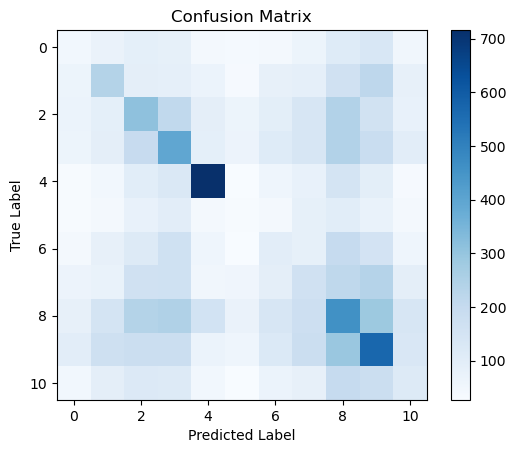

In [32]:
plt.imshow(conf, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Conclusion

This model achieves 20% accuracy in the prediction of crime type based on the given features, which is double of a random predictor that has only 10%. This accuracy is expected not to be high given the complex situation of the task, that is there are much more external factors that can influence when, where, and how crime happen, and all those information aren't inclued here. As a matter of fact, there is no such dataset that could capture all such details. Nevertheless, this model already demonstrate a over-baseline predictability from some simple feature engineering, and it also predict much better for particular tasks (crime 4, 8, 9, etc.). This project illustrates the potential to build a more well-rounded predictor that could better capture the crime pattern and help locals to defend against crime.